In [8]:
import torch
import torch.nn.functional as F
from torch import nn

import torchvision.models as models
from resnext import ResNeXt101

class Base_OHAZE(nn.Module):
    def __init__(self):
        super(Base_OHAZE, self).__init__()
        rgb_mean = (0.47421, 0.50878, 0.56789)
        self.mean_in = nn.Parameter(torch.Tensor(rgb_mean).view(1, 3, 1, 1), requires_grad=False)
        rgb_std = (0.10168, 0.10488, 0.11524)
        self.std_in = nn.Parameter(torch.Tensor(rgb_std).view(1, 3, 1, 1), requires_grad=False)

        rgb_mean = (0.35851, 0.35316, 0.34425)
        self.mean_out = nn.Parameter(torch.Tensor(rgb_mean).view(1, 3, 1, 1), requires_grad=False)
        rgb_std = (0.16391, 0.16174, 0.17148)
        self.std_out = nn.Parameter(torch.Tensor(rgb_std).view(1, 3, 1, 1), requires_grad=False)

In [21]:
class DM2FNet_woPhy_mod(Base_OHAZE):
    def __init__(self, num_features=64, arch='resnext101_32x8d'):
        super(DM2FNet_woPhy_mod, self).__init__()
        self.num_features = num_features

        # resnext = ResNeXt101Syn()
        # self.layer0 = resnext.layer0
        # self.layer1 = resnext.layer1
        # self.layer2 = resnext.layer2
        # self.layer3 = resnext.layer3
        # self.layer4 = resnext.layer4

        assert arch in ['resnet50', 'resnet101',
                        'resnet152', 'resnext50_32x4d', 'resnext101_32x8d']
        backbone = models.__dict__[arch](pretrained=True)
        del backbone.fc
        self.backbone = backbone

        self.down0 = nn.Sequential(
            nn.Conv2d(64, num_features, kernel_size=1), nn.SELU(),
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1), nn.SELU(),
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1), nn.SELU()
        )
        self.down1 = nn.Sequential(
            nn.Conv2d(256, num_features, kernel_size=1), nn.SELU(),
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1), nn.SELU(),
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1), nn.SELU()
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(512, num_features, kernel_size=1), nn.SELU(),
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1), nn.SELU()
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(1024, num_features, kernel_size=1), nn.SELU()
        )
        self.down4 = nn.Sequential(
            nn.Conv2d(2048, num_features, kernel_size=1), nn.SELU()
        )

        self.fuse3 = nn.Sequential(
            nn.Conv2d(num_features * 2, num_features, kernel_size=3, padding=1), nn.SELU(),
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1), nn.SELU(),
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1)
        )
        self.fuse2 = nn.Sequential(
            nn.Conv2d(num_features * 2, num_features, kernel_size=3, padding=1), nn.SELU(),
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1), nn.SELU(),
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1)
        )
        self.fuse1 = nn.Sequential(
            nn.Conv2d(num_features * 2, num_features, kernel_size=3, padding=1), nn.SELU(),
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1), nn.SELU(),
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1)
        )
        self.fuse0 = nn.Sequential(
            nn.Conv2d(num_features * 2, num_features, kernel_size=3, padding=1), nn.SELU(),
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1), nn.SELU(),
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1)
        )

        self.fuse3_attention = nn.Sequential(
            nn.Conv2d(num_features * 2, num_features, kernel_size=3, padding=1), nn.SELU(),
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1), nn.SELU(),
            nn.Conv2d(num_features, num_features, kernel_size=1), nn.Sigmoid()
        )
        self.fuse2_attention = nn.Sequential(
            nn.Conv2d(num_features * 2, num_features, kernel_size=3, padding=1), nn.SELU(),
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1), nn.SELU(),
            nn.Conv2d(num_features, num_features, kernel_size=1), nn.Sigmoid()
        )
        self.fuse1_attention = nn.Sequential(
            nn.Conv2d(num_features * 2, num_features, kernel_size=3, padding=1), nn.SELU(),
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1), nn.SELU(),
            nn.Conv2d(num_features, num_features, kernel_size=1), nn.Sigmoid()
        )
        self.fuse0_attention = nn.Sequential(
            nn.Conv2d(num_features * 2, num_features, kernel_size=3, padding=1), nn.SELU(),
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1), nn.SELU(),
            nn.Conv2d(num_features, num_features, kernel_size=1), nn.Sigmoid()
        )

        self.p0 = nn.Sequential(
            nn.Conv2d(num_features, num_features // 2, kernel_size=3, padding=1), nn.SELU(),
            nn.Conv2d(num_features // 2, 3, kernel_size=1)
        )
        self.p1 = nn.Sequential(
            nn.Conv2d(num_features, num_features // 2, kernel_size=3, padding=1), nn.SELU(),
            nn.Conv2d(num_features // 2, 3, kernel_size=1)
        )
        self.p2 = nn.Sequential(
            nn.Conv2d(num_features, num_features // 2, kernel_size=3, padding=1), nn.SELU(),
            nn.Conv2d(num_features // 2, 3, kernel_size=1)
        )
        # self.p2_1 = nn.Sequential(
        #     nn.Conv2d(num_features, num_features // 2, kernel_size=3, padding=1), nn.SELU(),
        #     nn.Conv2d(num_features // 2, 3, kernel_size=1)
        # )
        self.p3 = nn.Sequential(
            nn.Conv2d(num_features, num_features // 2, kernel_size=3, padding=1), nn.SELU(),
            nn.Conv2d(num_features // 2, 3, kernel_size=1)
        )
        # self.p3_1 = nn.Sequential(
        #     nn.Conv2d(num_features, num_features // 2, kernel_size=3, padding=1), nn.SELU(),
        #     nn.Conv2d(num_features // 2, 3, kernel_size=1)
        # )

        self.attentional_fusion = nn.Sequential(
            nn.Conv2d(num_features, num_features // 2, kernel_size=3, padding=1), nn.SELU(),
            nn.Conv2d(num_features // 2, num_features // 2, kernel_size=3, padding=1), nn.SELU(),
            nn.Conv2d(num_features // 2, 12, kernel_size=3, padding=1)
        )

        # self.vgg = VGGF()

        for m in self.modules():
            if isinstance(m, nn.SELU) or isinstance(m, nn.ReLU):
                m.inplace = True

    def forward(self, x0):
        x = (x0 - self.mean_in) / self.std_in

        backbone = self.backbone

        layer0 = backbone.conv1(x)
        layer0 = backbone.bn1(layer0)
        layer0 = backbone.relu(layer0)
        layer0 = backbone.maxpool(layer0)

        layer1 = backbone.layer1(layer0)
        layer2 = backbone.layer2(layer1)
        layer3 = backbone.layer3(layer2)
        layer4 = backbone.layer4(layer3)

        down0 = self.down0(layer0)
        down1 = self.down1(layer1)
        down2 = self.down2(layer2)
        down3 = self.down3(layer3)
        down4 = self.down4(layer4)

        down4 = F.upsample(down4, size=down3.size()[2:], mode='bilinear')
        fuse3_attention = self.fuse3_attention(torch.cat((down4, down3), 1))
        f = down4 + self.fuse3(torch.cat((down4, fuse3_attention * down3), 1))

        f = F.upsample(f, size=down2.size()[2:], mode='bilinear')
        fuse2_attention = self.fuse2_attention(torch.cat((f, down2), 1))
        f = f + self.fuse2(torch.cat((f, fuse2_attention * down2), 1))

        f = F.upsample(f, size=down1.size()[2:], mode='bilinear')
        fuse1_attention = self.fuse1_attention(torch.cat((f, down1), 1))
        f = f + self.fuse1(torch.cat((f, fuse1_attention * down1), 1))

        f = F.upsample(f, size=down0.size()[2:], mode='bilinear')
        fuse0_attention = self.fuse0_attention(torch.cat((f, down0), 1))
        f = f + self.fuse0(torch.cat((f, fuse0_attention * down0), 1))

        log_x0 = torch.log(x0.clamp(min=1e-8))
        log_log_x0_inverse = torch.log(torch.log(1 / x0.clamp(min=1e-8, max=(1 - 1e-8))))

        # J1 = I * exp(R1) = exp(log I + R1)
        x_p0 = torch.exp(log_x0 + F.upsample(self.p0(f), size=x0.size()[2:], mode='bilinear')).clamp(min=0, max=1)

        # J2 = I + R2
        x_p1 = ((x + F.upsample(self.p1(f), size=x0.size()[2:], mode='bilinear')) * self.std_out + self.mean_out)\
            .clamp(min=0., max=1.)

        # ???
        # log_x_p2_0 = torch.log(
        #     ((x + F.upsample(self.p2_0(f), size=x0.size()[2:], mode='bilinear')) * self.std_out + self.mean_out)
        #         .clamp(min=1e-8))
        # x_p2 = torch.exp(log_x_p2_0 + F.upsample(self.p2_1(f), size=x0.size()[2:], mode='bilinear'))\
        #     .clamp(min=0., max=1.)

        # log_x_p3_0 = torch.exp(log_log_x0_inverse + F.upsample(self.p3_0(f), size=x0.size()[2:], mode='bilinear'))
        # x_p3 = torch.exp(-log_x_p3_0 + F.upsample(self.p3_1(f), size=x0.size()[2:], mode='bilinear')).clamp(min=0, max=1)

        # J3 = I exp(exp(R3))
        x_p2 = torch.exp(-torch.exp(log_log_x0_inverse + F.upsample(self.p2(f), size=x0.size()[2:], mode='bilinear'))).clamp(min=0., max=1.)

        # J4 = log(1 + I * exp(R4))
        x_p3 = (torch.log(1 + torch.exp(log_x0 + F.upsample(self.p3(f), size=x0.size()[2:], mode='bilinear')))).clamp(min=0., max=1.)

        attention_fusion = F.upsample(self.attentional_fusion(f), size=x0.size()[2:], mode='bilinear')
        x_fusion = torch.cat((torch.sum(F.softmax(attention_fusion[:, : 4, :, :], 1) * torch.stack((x_p0[:, 0, :, :], 
                                                                                                    x_p1[:, 0, :, :], 
                                                                                                    x_p2[:, 0, :, :], 
                                                                                                    x_p3[:, 0, :, :]), 1), 1, True),
                              torch.sum(F.softmax(attention_fusion[:, 4: 8, :, :], 1) * torch.stack((x_p0[:, 1, :, :],
                                                                                                     x_p1[:, 1, :, :],
                                                                                                     x_p2[:, 1, :, :],
                                                                                                     x_p3[:, 1, :, :]), 1), 1, True),
                              torch.sum(F.softmax(attention_fusion[:, 8:, :, :], 1) * torch.stack((x_p0[:, 2, :, :],
                                                                                                   x_p1[:, 2, :, :],
                                                                                                   x_p2[:, 2, :, :],
                                                                                                   x_p3[:, 2, :, :]), 1), 1, True)),
                             1).clamp(min=0, max=1)

        if self.training:
            return x_fusion, x_p0, x_p1, x_p2, x_p3
        else:
            return x_fusion

In [22]:
model = DM2FNet_woPhy_mod()

In [23]:
xi = torch.rand([5,3,456,789])
model(xi)[0].shape

torch.Size([5, 64, 114, 198])
torch.Size([5, 256, 114, 198])
torch.Size([5, 512, 57, 99])
torch.Size([5, 1024, 29, 50])
torch.Size([5, 2048, 15, 25])
torch.Size([5, 3, 456, 789])


torch.Size([5, 3, 456, 789])

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
import os

# 定义神经网络模型
class HistogramEqualizationNet(nn.Module):
    def __init__(self):
        super(HistogramEqualizationNet, self).__init__()
        self.fc1 = nn.Linear(256 * 3, 64)
        self.fc2 = nn.Linear(64, 6)  # 输出6个参数

    def forward(self, x):
        x = x.view(-1, 256 * 3)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 自定义数据集类
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_image = cv2.merge([clahe.apply(image_rgb[:, :, i]) for i in range(3)])
        
        if self.transform:
            image = self.transform(image_rgb)
            clahe_image = self.transform(clahe_image)
        
        return image, clahe_image

# 数据预处理
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor()
])

# 获取图像路径
image_dir = '/remote-home/lijuncheng/project/course/DIP/SingleImageDehazing/data/RESIDE/OTS/clear'
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.jpg')]

# 创建数据集和数据加载器
dataset = ImageDataset(image_paths, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# 初始化模型、损失函数和优化器
model = HistogramEqualizationNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 计算直方图函数
def calculate_histogram(image):
    histograms = []
    for i in range(3):
        hist = torch.histc(image[i, :, :].view(-1), bins=256, min=0, max=255)
        histograms.append(hist)
    return torch.cat(histograms)

# 参数化的直方图均衡化函数
def parametric_histogram_equalization(image, params):
    kr, kg, kb, ar, ag, ab = params
    r_channel = kr * image[0] + ar
    g_channel = kg * image[1] + ag
    b_channel = kb * image[2] + ab
    equalized_image = torch.stack([r_channel, g_channel, b_channel])
    return equalized_image.clamp(0, 1)

# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
    for images, clahe_images in dataloader:
        histograms = torch.stack([calculate_histogram(img) for img in images])
        outputs = model(histograms)
        
        transformed_images = torch.stack([parametric_histogram_equalization(img, output) for img, output in zip(images, outputs)])
        
        loss = criterion(transformed_images, clahe_images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 保存模型
# torch.save(model.state_dict(), 'histogram_equalization_net.pth')

# 应用训练好的模型进行直方图均衡化
def apply_parametric_histogram_equalization(model, image):
    image_tensor = transform(image).unsqueeze(0)
    histogram = calculate_histogram(image_tensor)
    with torch.no_grad():
        params = model(histogram.unsqueeze(0)).squeeze(0)
        equalized_image = parametric_histogram_equalization(image_tensor.squeeze(0), params).permute(1, 2, 0).numpy()
    return equalized_image

# 读取并处理新图像
test_image_path = '/remote-home/lijuncheng/project/course/DIP/SingleImageDehazing/data/RESIDE/OTS/haze/0025_0.8_0.2.jpg'
test_image = cv2.imread(test_image_path)
equalized_image = apply_parametric_histogram_equalization(model, test_image)

# 显示结果
cv2.imshow('Original Image', cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
cv2.imshow('Equalized Image', equalized_image)
cv2.imshow('gt Equalized Image', equalized_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


Epoch [1/10], Loss: 0.3164
Epoch [2/10], Loss: 0.3122
Epoch [3/10], Loss: 0.3154
Epoch [4/10], Loss: 0.3165
Epoch [5/10], Loss: 0.3176
Epoch [6/10], Loss: 0.3251
Epoch [7/10], Loss: 0.3192
Epoch [8/10], Loss: 0.3273
Epoch [9/10], Loss: 0.3203
Epoch [10/10], Loss: 0.3164


IndexError: index 1 is out of bounds for dimension 0 with size 1

In [17]:
image1 = cv2.imread('/remote-home/lijuncheng/project/course/DIP/SingleImageDehazing/data/HazeRD/data/simu/IMG_7460_50.jpg')
image2 = cv2.imread('/remote-home/lijuncheng/project/course/DIP/SingleImageDehazing/data/HazeRD/data/img/IMG_7460_RGB.jpg')

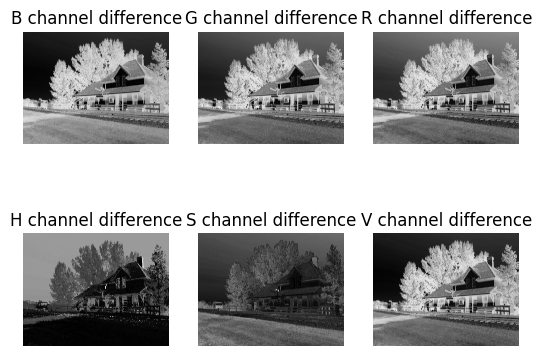

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取两张图片
# 确保两张图片的大小一致
if image1.shape != image2.shape:
    raise ValueError("The images have different sizes or channels")

# 计算RGB通道的差异
diff_rgb = cv2.absdiff(image1, image2)

# 转换为HSV颜色空间
hsv1 = cv2.cvtColor(image1, cv2.COLOR_BGR2HSV)
hsv2 = cv2.cvtColor(image2, cv2.COLOR_BGR2HSV)

# 计算HSV通道的差异
diff_hsv = cv2.absdiff(hsv1, hsv2)

# 分离RGB和HSV通道
channels_rgb = ['B', 'G', 'R']
channels_hsv = ['H', 'S', 'V']

# 显示RGB通道差异
for i, channel in enumerate(channels_rgb):
    plt.subplot(2, 3, i+1)
    plt.imshow(diff_rgb[:,:,i], cmap='gray')
    plt.title(f'{channel} channel difference')
    plt.axis('off')

# 显示HSV通道差异
for i, channel in enumerate(channels_hsv):
    plt.subplot(2, 3, i+4)
    plt.imshow(diff_hsv[:,:,i], cmap='gray')
    plt.title(f'{channel} channel difference')
    plt.axis('off')

plt.show()

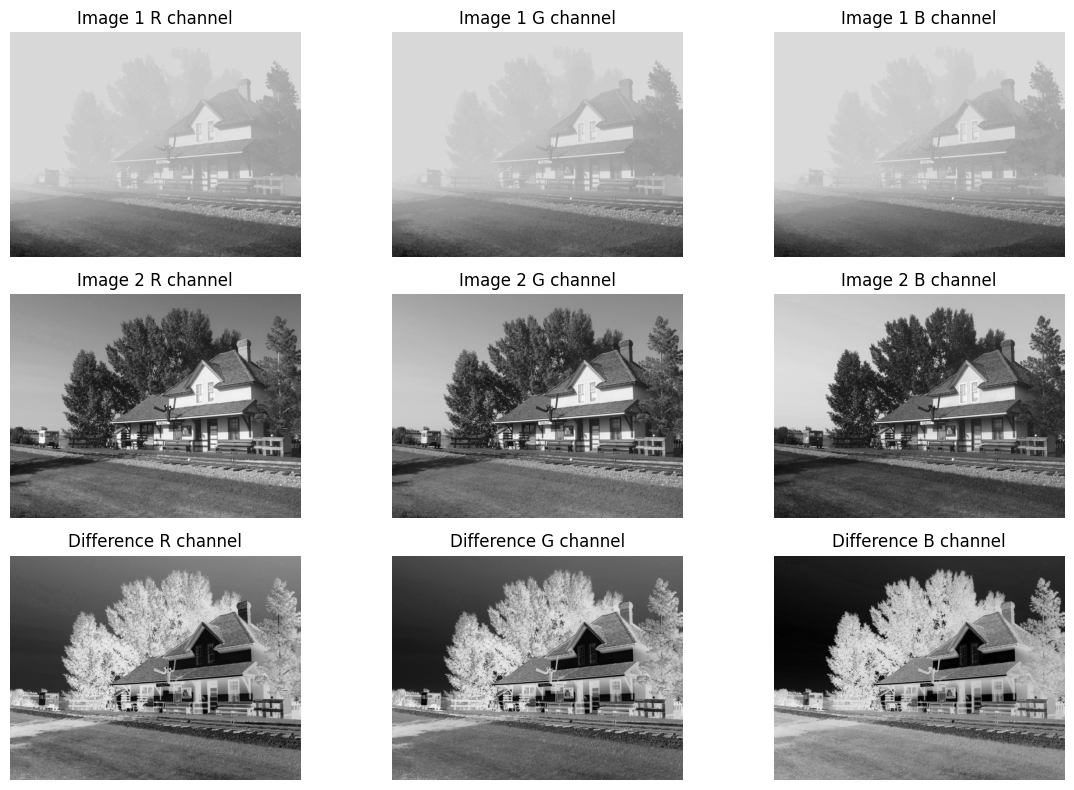

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取两张图片

# 确保两张图片的大小一致
if image1.shape != image2.shape:
    raise ValueError("The images have different sizes or channels")

# 转换为RGB颜色空间（OpenCV读取的图片是BGR格式）
image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# 转换为HSV颜色空间
image1_hsv = cv2.cvtColor(image1, cv2.COLOR_BGR2HSV)
image2_hsv = cv2.cvtColor(image2, cv2.COLOR_BGR2HSV)

# 计算RGB通道的差异
diff_rgb = cv2.absdiff(image1_rgb, image2_rgb)

# 计算HSV通道的差异
diff_hsv = cv2.absdiff(image1_hsv, image2_hsv)

# 分离RGB和HSV通道
channels_rgb = ['R', 'G', 'B']
channels_hsv = ['H', 'S', 'V']

# 设置图形大小
plt.figure(figsize=(12, 8))

# 显示第一张图片的RGB通道
for i, channel in enumerate(channels_rgb):
    plt.subplot(3, 3, i+1)
    plt.imshow(image1_rgb[:,:,i], cmap='gray')
    plt.title(f'Image 1 {channel} channel')
    plt.axis('off')

# 显示第二张图片的RGB通道
for i, channel in enumerate(channels_rgb):
    plt.subplot(3, 3, i+4)
    plt.imshow(image2_rgb[:,:,i], cmap='gray')
    plt.title(f'Image 2 {channel} channel')
    plt.axis('off')

# 显示RGB通道差异
for i, channel in enumerate(channels_rgb):
    plt.subplot(3, 3, i+7)
    plt.imshow(diff_rgb[:,:,i], cmap='gray')
    plt.title(f'Difference {channel} channel')
    plt.axis('off')

# # 显示第一张图片的HSV通道
# for i, channel in enumerate(channels_hsv):
#     plt.subplot(4, 4, i+9)
#     plt.imshow(image1_hsv[:,:,i], cmap='gray')
#     plt.title(f'Image 1 {channel} channel')
#     plt.axis('off')

# # 显示第二张图片的HSV通道
# for i, channel in enumerate(channels_hsv):
#     plt.subplot(4, 4, i+13)
#     plt.imshow(image2_hsv[:,:,i], cmap='gray')
#     plt.title(f'Image 2 {channel} channel')
#     plt.axis('off')

# # 显示HSV通道差异
# for i, channel in enumerate(channels_hsv):
#     plt.subplot(4, 3, i+16)
#     plt.imshow(diff_hsv[:,:,i], cmap='gray')
#     plt.title(f'Difference {channel} channel')
#     plt.axis('off')

plt.tight_layout()
plt.show()


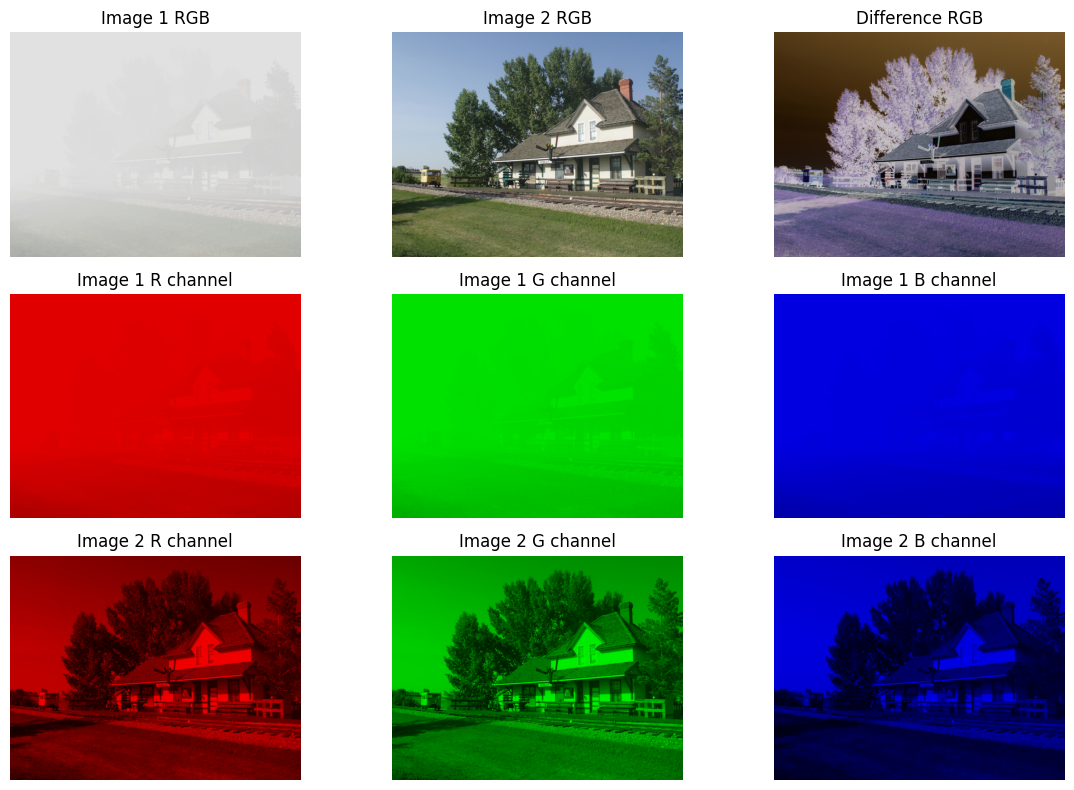

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取两张图片

# 确保两张图片的大小一致
if image1.shape != image2.shape:
    raise ValueError("The images have different sizes or channels")

# 转换为RGB颜色空间（OpenCV读取的图片是BGR格式）
image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# 设置图形大小
plt.figure(figsize=(12, 8))

# 显示第一张图片的RGB通道
plt.subplot(3, 3, 1)
plt.imshow(image1_rgb)
plt.title('Image 1 RGB')
plt.axis('off')

# 显示第二张图片的RGB通道
plt.subplot(3, 3, 2)
plt.imshow(image2_rgb)
plt.title('Image 2 RGB')
plt.axis('off')

# 计算RGB通道的差异
diff_rgb = cv2.absdiff(image1_rgb, image2_rgb)

# 显示RGB通道差异
plt.subplot(3, 3, 3)
plt.imshow(diff_rgb)
plt.title('Difference RGB')
plt.axis('off')

# 分离并显示第一张图片的单独RGB通道
channels_rgb = ['R', 'G', 'B']
for i, channel in enumerate(channels_rgb):
    single_channel_img1 = np.zeros_like(image1_rgb)
    single_channel_img1[:,:,i] = image1_rgb[:,:,i]
    plt.subplot(3, 3, i + 4)
    plt.imshow(single_channel_img1)
    plt.title(f'Image 1 {channel} channel')
    plt.axis('off')

channels_rgb = ['R', 'G', 'B']
for i, channel in enumerate(channels_rgb):
    single_channel_img2 = np.zeros_like(image2_rgb)
    single_channel_img2[:,:,i] = image2_rgb[:,:,i]
    plt.subplot(3, 3, i + 7)
    plt.imshow(single_channel_img2)
    plt.title(f'Image 2 {channel} channel')
    plt.axis('off')

# 显示图像
plt.tight_layout()
plt.show()


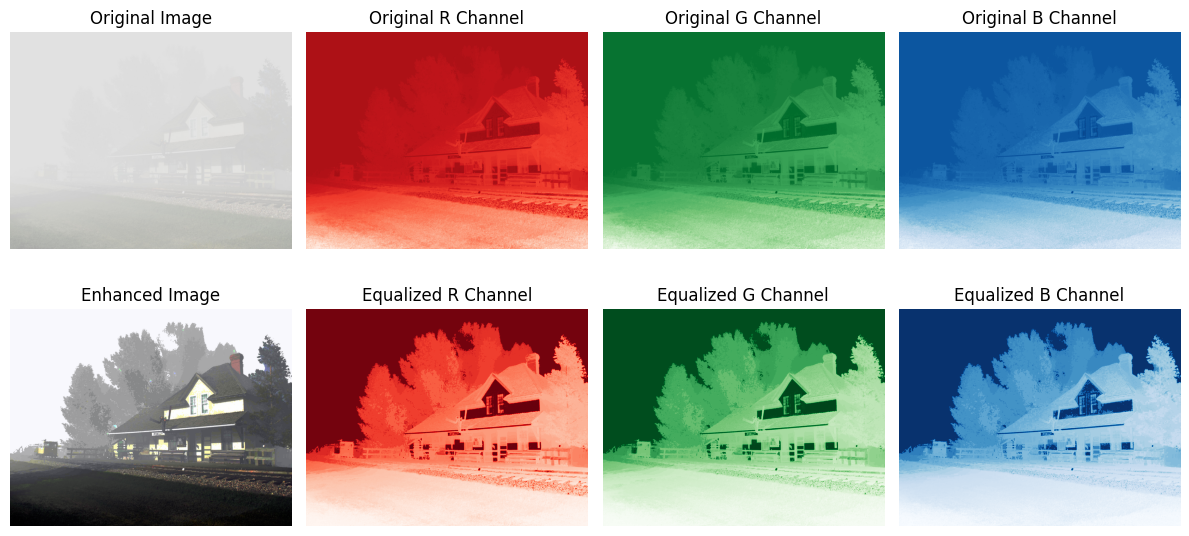

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取图片

# 确保图像是RGB格式（OpenCV读取的图片是BGR格式）
image_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# 分离RGB通道
r, g, b = cv2.split(image_rgb)

# 应用直方图均衡化来提高对比度
r_eq = cv2.equalizeHist(r)
g_eq = cv2.equalizeHist(g)
b_eq = cv2.equalizeHist(b)

r_eq2 = cv2.equalizeHist(r_eq)
g_eq2 = cv2.equalizeHist(g_eq)
b_eq2 = cv2.equalizeHist(b_eq)

# 合并均衡化后的通道
image_eq = cv2.merge((r_eq2, g_eq2, b_eq2))

# 设置图形大小
plt.figure(figsize=(12, 6))

# 显示原始图像和增强后的图像
plt.subplot(2, 4, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')

# 显示原始的RGB通道
plt.subplot(2, 4, 2)
plt.imshow(r, cmap='Reds')
plt.title('Original R Channel')
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(g, cmap='Greens')
plt.title('Original G Channel')
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(b, cmap='Blues')
plt.title('Original B Channel')
plt.axis('off')

# 显示增强后的RGB通道
plt.subplot(2, 4, 6)
plt.imshow(r_eq2, cmap='Reds')
plt.title('Equalized R Channel')
plt.axis('off')

plt.subplot(2, 4, 7)
plt.imshow(g_eq2, cmap='Greens')
plt.title('Equalized G Channel')
plt.axis('off')

plt.subplot(2, 4, 8)
plt.imshow(b_eq2, cmap='Blues')
plt.title('Equalized B Channel')
plt.axis('off')

# 显示增强后的图像
plt.subplot(2, 4, 5)
plt.imshow(image_eq)
plt.title('Enhanced Image')
plt.axis('off')

plt.tight_layout()
plt.show()


In [50]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 打开两张图片
image1 = Image.open('/remote-home/lijuncheng/project/course/DIP/SingleImageDehazing/data/HazeRD/data/simu/IMG_7460_50.jpg')
image2 = Image.open('/remote-home/lijuncheng/project/course/DIP/SingleImageDehazing/data/HazeRD/data/img/IMG_7460_RGB.jpg')

# 将图片转换为numpy数组
image1_np = np.array(image1)
image2_np = np.array(image2)

# 确保两张图片大小一致
if image1_np.shape != image2_np.shape:
    raise ValueError("The images must have the same dimensions.")

# 计算RGB通道的比值
ratio = np.zeros_like(image1_np, dtype=float)
for i in range(3):  # 对于每个RGB通道
    ratio[..., i] = np.divide(image1_np[..., i], image2_np[..., i], out=np.zeros_like(image1_np[..., i], dtype=float), where=image2_np[..., i] != 0)

print(ratio[..., 2])
# # 绘制比值的分布
# fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# colors = ['Red', 'Green', 'Blue']

# for i in range(3):
#     axs[i].hist(ratio[..., i].ravel(), bins=256, color=colors[i].lower(), alpha=0.7)
#     axs[i].set_title(f'{colors[i]} Channel Ratio Distribution')
#     axs[i].set_xlabel('Ratio')
#     axs[i].set_ylabel('Frequency')
#     axs[i].set_xlim(1, 20)

# plt.tight_layout()
# plt.show()


[[ 1.10294118  1.10294118  1.10294118 ...  1.2295082   1.2295082
   1.2295082 ]
 [ 1.10294118  1.10294118  1.10294118 ...  1.2295082   1.2295082
   1.2295082 ]
 [ 1.10294118  1.10294118  1.10294118 ...  1.2295082   1.2295082
   1.2295082 ]
 ...
 [ 5.          4.52631579  4.57894737 ...  2.01123596  2.44444444
   3.03508772]
 [ 9.33333333  5.18181818  4.35       ...  1.96703297  2.34666667
   2.79032258]
 [20.75        5.48387097  3.80434783 ...  2.13095238  2.44444444
   2.91525424]]


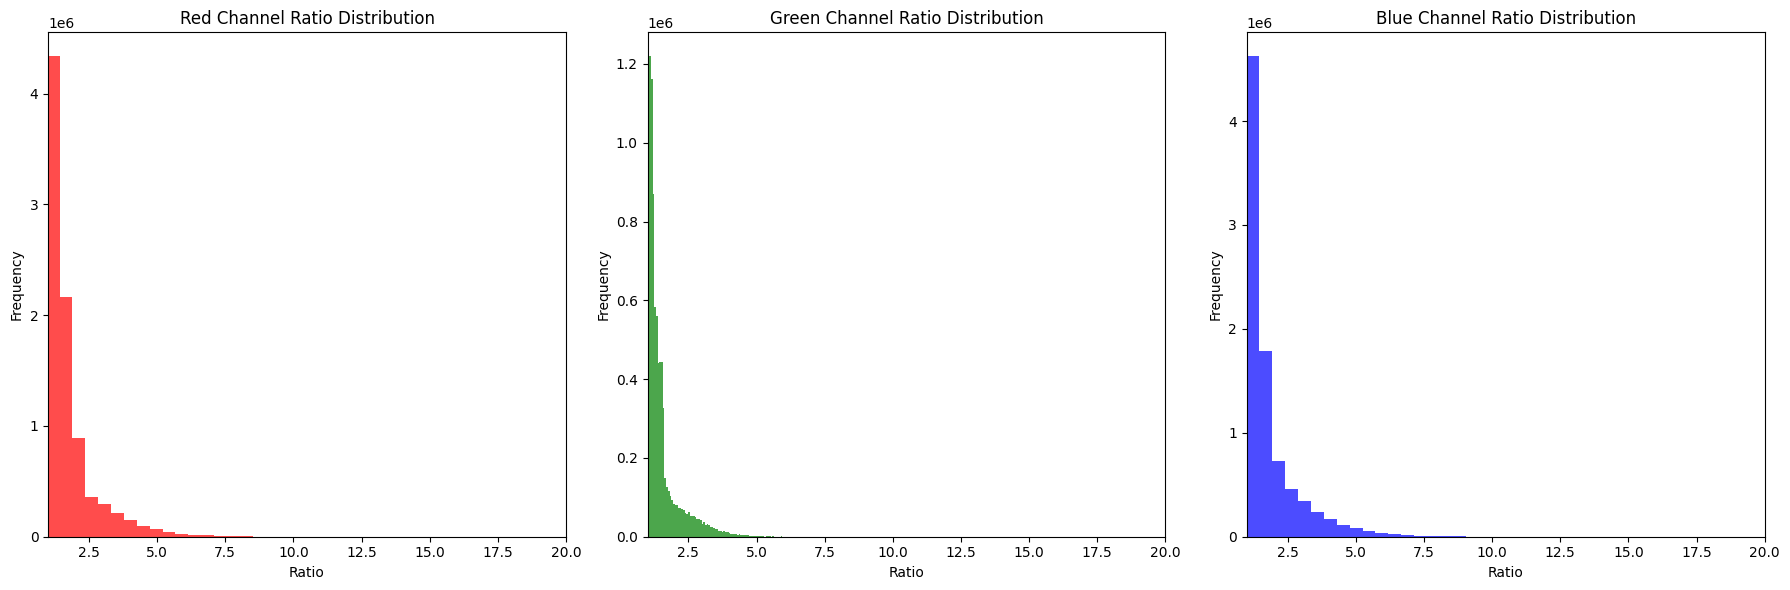

In [34]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 打开两张图片
image1 = Image.open('/remote-home/lijuncheng/project/course/DIP/SingleImageDehazing/data/HazeRD/data/simu/IMG_7460_500.jpg')
image2 = Image.open('/remote-home/lijuncheng/project/course/DIP/SingleImageDehazing/data/HazeRD/data/img/IMG_7460_RGB.jpg')

# 将图片转换为numpy数组
image1_np = np.array(image1)
image2_np = np.array(image2)

# 确保两张图片大小一致
if image1_np.shape != image2_np.shape:
    raise ValueError("The images must have the same dimensions.")

# 计算RGB通道的比值
ratio = np.zeros_like(image1_np, dtype=float)
for i in range(3):  # 对于每个RGB通道
    ratio[..., i] = np.divide(image1_np[..., i], image2_np[..., i], out=np.zeros_like(image1_np[..., i], dtype=float), where=image2_np[..., i] != 0)

# 绘制比值的分布
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
colors = ['Red', 'Green', 'Blue']

for i in range(3):
    axs[i].hist(ratio[..., i].ravel(), bins=256, color=colors[i].lower(), alpha=0.7)
    axs[i].set_title(f'{colors[i]} Channel Ratio Distribution')
    axs[i].set_xlabel('Ratio')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlim(1, 20)

plt.tight_layout()
plt.show()

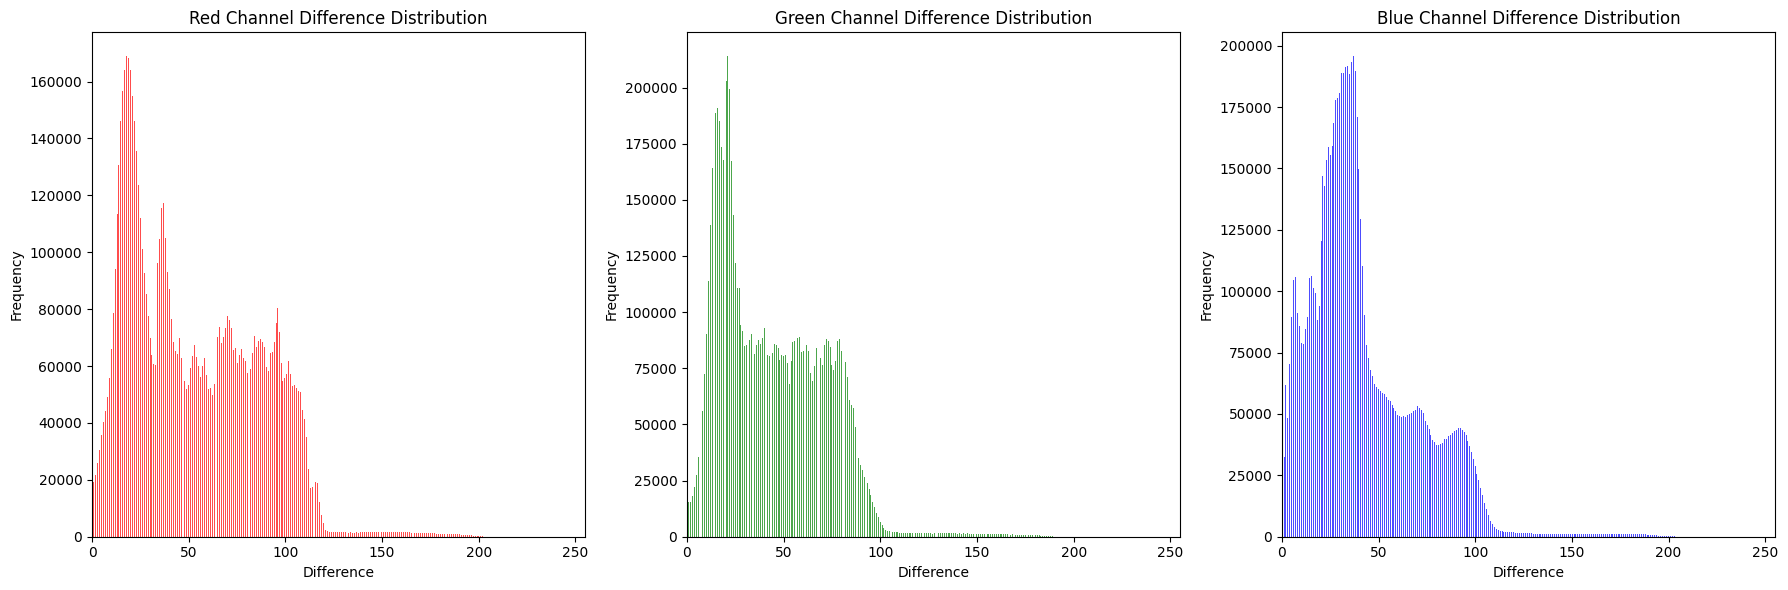

In [36]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 打开两张图片
image1 = Image.open('/remote-home/lijuncheng/project/course/DIP/SingleImageDehazing/data/HazeRD/data/simu/IMG_7460_500.jpg')
image2 = Image.open('/remote-home/lijuncheng/project/course/DIP/SingleImageDehazing/data/HazeRD/data/img/IMG_7460_RGB.jpg')

# 将图片转换为numpy数组
image1_np = np.array(image1)
image2_np = np.array(image2)

# 确保两张图片大小一致
if image1_np.shape != image2_np.shape:
    raise ValueError("The images must have the same dimensions.")

# 计算RGB通道的差值
difference = image1_np.astype(np.int16) - image2_np.astype(np.int16)

# 设置横坐标的区间范围
x_min, x_max = 0, 255  # 像素值差异的范围

# 绘制差值的分布
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
colors = ['Red', 'Green', 'Blue']

for i in range(3):
    axs[i].hist(difference[..., i].ravel(), bins=512, color=colors[i].lower(), alpha=0.7)
    axs[i].set_title(f'{colors[i]} Channel Difference Distribution')
    axs[i].set_xlabel('Difference')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlim(x_min, x_max)  # 设置横坐标范围

plt.tight_layout()
plt.show()


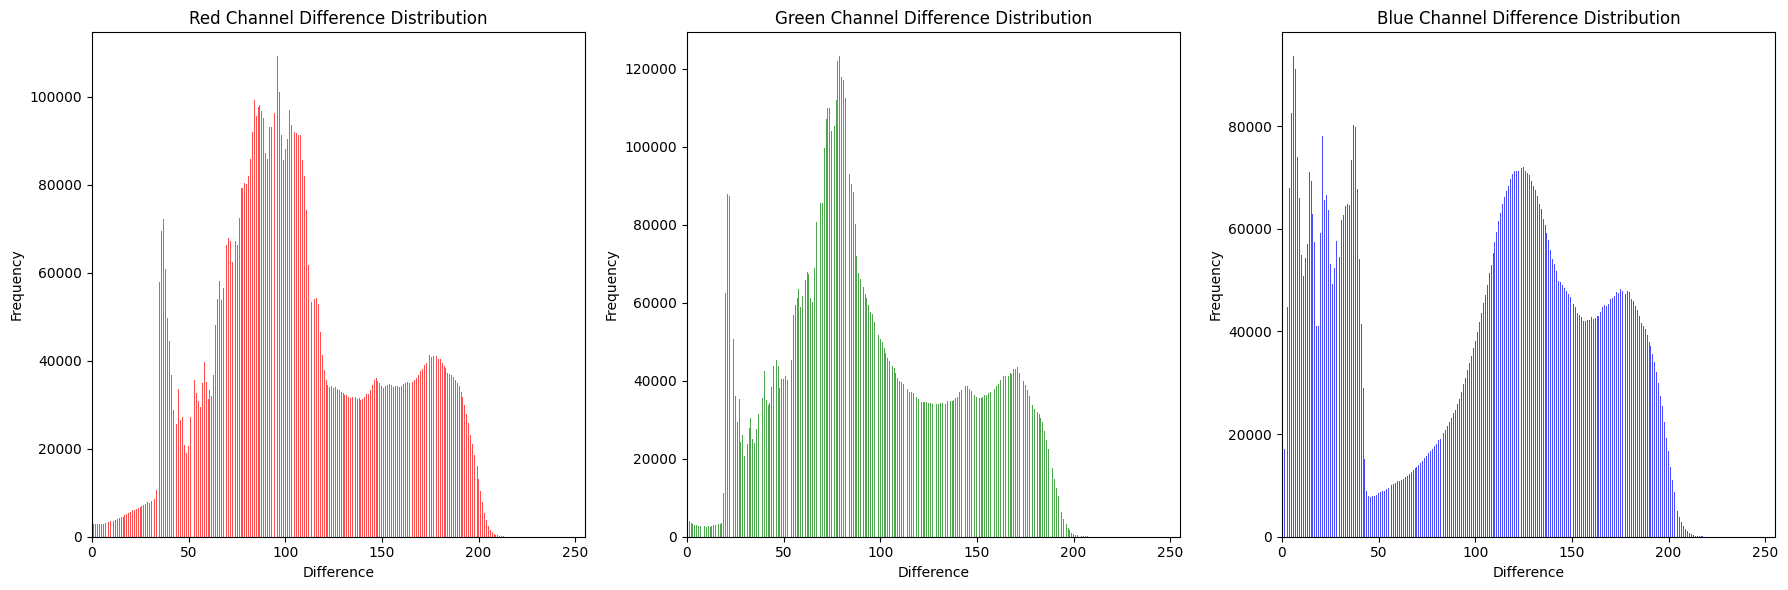

In [40]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 打开两张图片
image1 = Image.open('/remote-home/lijuncheng/project/course/DIP/SingleImageDehazing/data/HazeRD/data/simu/IMG_7460_50.jpg')
image2 = Image.open('/remote-home/lijuncheng/project/course/DIP/SingleImageDehazing/data/HazeRD/data/img/IMG_7460_RGB.jpg')

# 将图片转换为numpy数组
image1_np = np.array(image1)
image2_np = np.array(image2)

# 确保两张图片大小一致
if image1_np.shape != image2_np.shape:
    raise ValueError("The images must have the same dimensions.")

# 计算RGB通道的差值
difference = image1_np.astype(np.int16) - image2_np.astype(np.int16)

# 设置横坐标的区间范围
x_min, x_max = 0, 255  # 像素值差异的范围

# 绘制差值的分布
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
colors = ['Red', 'Green', 'Blue']

for i in range(3):
    axs[i].hist(difference[..., i].ravel(), bins=512, color=colors[i].lower(), alpha=0.7)
    axs[i].set_title(f'{colors[i]} Channel Difference Distribution')
    axs[i].set_xlabel('Difference')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlim(x_min, x_max)  # 设置横坐标范围

plt.tight_layout()
plt.show()

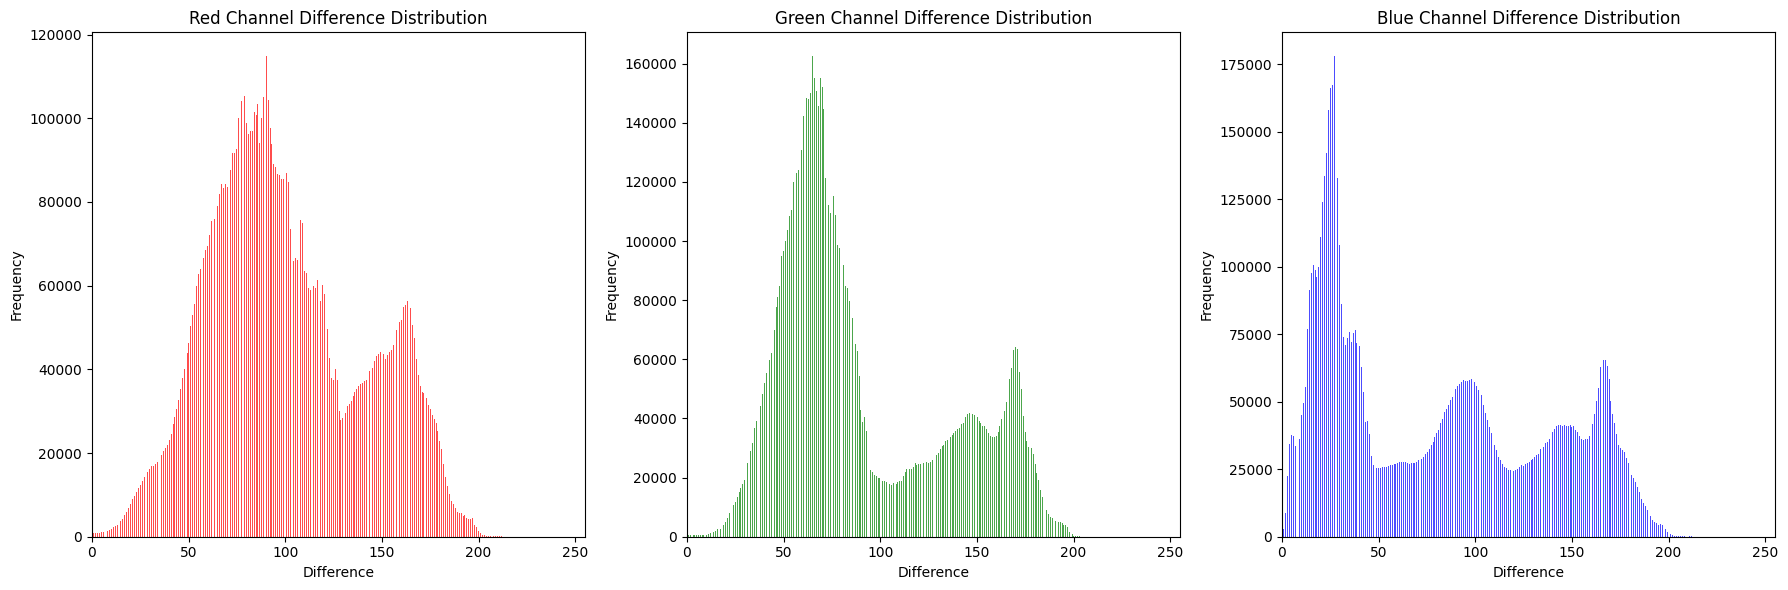

In [41]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 打开两张图片
image1 = Image.open('/remote-home/lijuncheng/project/course/DIP/SingleImageDehazing/data/HazeRD/data/simu/IMG_9562_50.jpg')
image2 = Image.open('/remote-home/lijuncheng/project/course/DIP/SingleImageDehazing/data/HazeRD/data/img/IMG_9562_RGB.jpg')

# 将图片转换为numpy数组
image1_np = np.array(image1)
image2_np = np.array(image2)

# 确保两张图片大小一致
if image1_np.shape != image2_np.shape:
    raise ValueError("The images must have the same dimensions.")

# 计算RGB通道的差值
difference = image1_np.astype(np.int16) - image2_np.astype(np.int16)

# 设置横坐标的区间范围
x_min, x_max = 0, 255  # 像素值差异的范围

# 绘制差值的分布
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
colors = ['Red', 'Green', 'Blue']

for i in range(3):
    axs[i].hist(difference[..., i].ravel(), bins=512, color=colors[i].lower(), alpha=0.7)
    axs[i].set_title(f'{colors[i]} Channel Difference Distribution')
    axs[i].set_xlabel('Difference')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlim(x_min, x_max)  # 设置横坐标范围

plt.tight_layout()
plt.show()

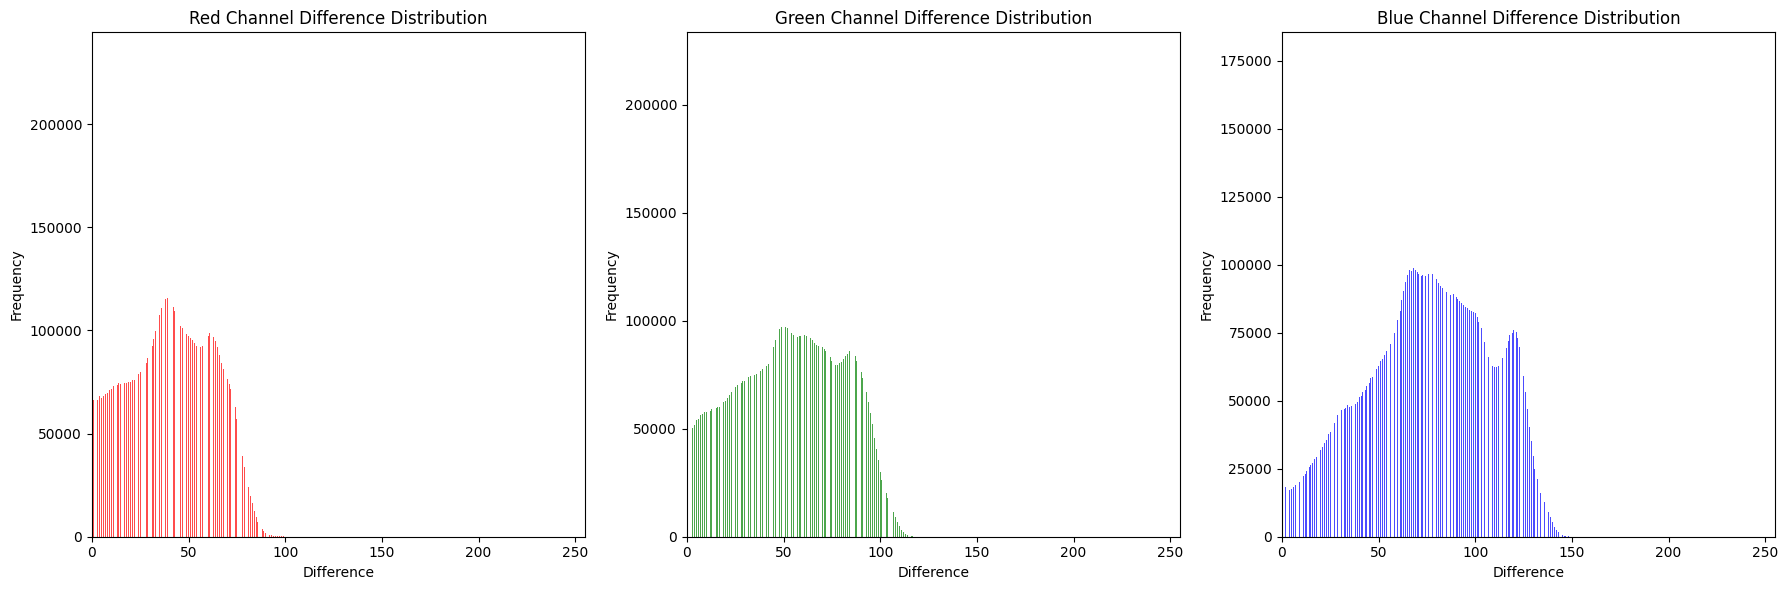

In [42]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 打开两张图片
image1 = Image.open('/remote-home/lijuncheng/project/course/DIP/SingleImageDehazing/data/O-Haze/# O-HAZY NTIRE 2018/hazy/45_outdoor_hazy.jpg')
image2 = Image.open('/remote-home/lijuncheng/project/course/DIP/SingleImageDehazing/data/O-Haze/# O-HAZY NTIRE 2018/GT/45_outdoor_GT.jpg')

# 将图片转换为numpy数组
image1_np = np.array(image1)
image2_np = np.array(image2)

# 确保两张图片大小一致
if image1_np.shape != image2_np.shape:
    raise ValueError("The images must have the same dimensions.")

# 计算RGB通道的差值
difference = image1_np.astype(np.int16) - image2_np.astype(np.int16)

# 设置横坐标的区间范围
x_min, x_max = 0, 255  # 像素值差异的范围

# 绘制差值的分布
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
colors = ['Red', 'Green', 'Blue']

for i in range(3):
    axs[i].hist(difference[..., i].ravel(), bins=512, color=colors[i].lower(), alpha=0.7)
    axs[i].set_title(f'{colors[i]} Channel Difference Distribution')
    axs[i].set_xlabel('Difference')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlim(x_min, x_max)  # 设置横坐标范围

plt.tight_layout()
plt.show()

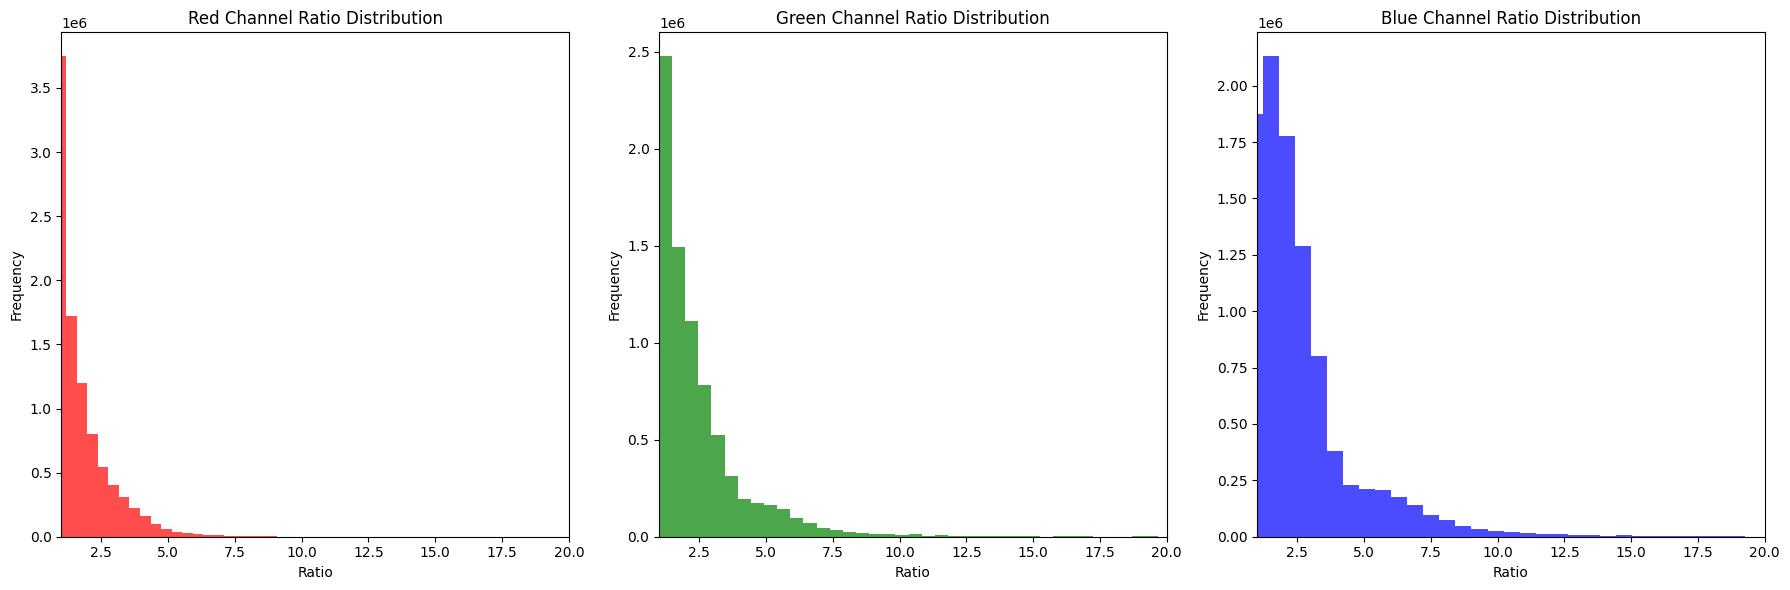

In [43]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 打开两张图片
image1 = Image.open('/remote-home/lijuncheng/project/course/DIP/SingleImageDehazing/data/O-Haze/# O-HAZY NTIRE 2018/hazy/45_outdoor_hazy.jpg')
image2 = Image.open('/remote-home/lijuncheng/project/course/DIP/SingleImageDehazing/data/O-Haze/# O-HAZY NTIRE 2018/GT/45_outdoor_GT.jpg')
# 将图片转换为numpy数组
image1_np = np.array(image1)
image2_np = np.array(image2)

# 确保两张图片大小一致
if image1_np.shape != image2_np.shape:
    raise ValueError("The images must have the same dimensions.")

# 计算RGB通道的比值
ratio = np.zeros_like(image1_np, dtype=float)
for i in range(3):  # 对于每个RGB通道
    ratio[..., i] = np.divide(image1_np[..., i], image2_np[..., i], out=np.zeros_like(image1_np[..., i], dtype=float), where=image2_np[..., i] != 0)

# 绘制比值的分布
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
colors = ['Red', 'Green', 'Blue']

for i in range(3):
    axs[i].hist(ratio[..., i].ravel(), bins=256, color=colors[i].lower(), alpha=0.7)
    axs[i].set_title(f'{colors[i]} Channel Ratio Distribution')
    axs[i].set_xlabel('Ratio')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlim(1, 20)

plt.tight_layout()
plt.show()


In [47]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 打开两张图片
image1 = Image.open('/remote-home/lijuncheng/project/course/DIP/SingleImageDehazing/data/O-Haze/# O-HAZY NTIRE 2018/hazy/45_outdoor_hazy.jpg')
image2 = Image.open('/remote-home/lijuncheng/project/course/DIP/SingleImageDehazing/data/O-Haze/# O-HAZY NTIRE 2018/GT/45_outdoor_GT.jpg')
# 将图片转换为numpy数组
image1_np = np.array(image1)
image2_np = np.array(image2)

# 确保两张图片大小一致
if image1_np.shape != image2_np.shape:
    raise ValueError("The images must have the same dimensions.")

# 计算RGB通道的比值
ratio = np.zeros_like(image1_np, dtype=float)
for i in range(3):  # 对于每个RGB通道
    ratio[..., i] = np.divide(image1_np[..., i], image2_np[..., i], out=np.zeros_like(image1_np[..., i], dtype=float), where=image2_np[..., i] != 0)

print(ratio[...,2])
# # 绘制比值的分布
# fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# colors = ['Red', 'Green', 'Blue']

# for i in range(3):
#     axs[i].hist(ratio[..., i].ravel(), bins=256, color=colors[i].lower(), alpha=0.7)
#     axs[i].set_title(f'{colors[i]} Channel Ratio Distribution')
#     axs[i].set_xlabel('Ratio')
#     axs[i].set_ylabel('Frequency')
#     axs[i].set_xlim(1, 20)

# plt.tight_layout()
# plt.show()

[[0.95698925 0.9516129  0.9516129  ... 0.953125   0.95287958 0.94764398]
 [0.9516129  0.95698925 0.95698925 ... 0.95287958 0.94764398 0.95789474]
 [0.94652406 0.94652406 0.95698925 ... 0.95287958 0.95263158 0.95789474]
 ...
 [1.54878049 1.38043478 1.42222222 ... 4.25       3.85714286 3.8       ]
 [1.69444444 1.46428571 1.47674419 ... 4.02941176 3.88571429 3.82857143]
 [2.18518519 1.76470588 1.72222222 ... 4.09090909 4.12121212 4.15151515]]
